### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Pixtral-12B-2409",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.10: Fast Llava patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    # We do NOT finetune vision & attention layers since Pixtral uses more memory!
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True,  # False if not finetuning language layers
    finetune_attention_modules = False, # False if not finetuning attention layers
    finetune_mlp_modules       = True,  # False if not finetuning MLP layers

    r = 8,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.vision_tower.transformer` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of general question and answering pairs. These datasets should be mixed with other finetunes to not make the model forget general tasks.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/llava-instruct-mix-vsft-mini). The full dataset is [here](https://huggingface.co/datasets/HuggingFaceH4/llava-instruct-mix-vsft).

In [ ]:
from datasets import load_dataset
dataset = load_dataset("unsloth/llava-instruct-mix-vsft-mini", split = "train")

README.md:   0%|          | 0.00/728 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/57.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1364 [00:00<?, ? examples/s]

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [ ]:
dataset

Dataset({
    features: ['messages', 'images'],
    num_rows: 8552
})

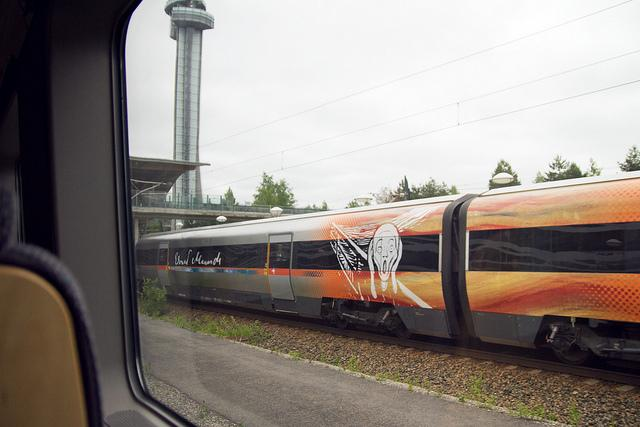

In [ ]:
dataset[2]["images"][0]

In [ ]:
dataset[2]["messages"]

[{'content': [{'index': 0, 'text': None, 'type': 'image'},
   {'index': None,
    'text': '\nWhat makes the train in the image unique compared to other trains?',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'index': None,
    'text': 'What sets the train in the image apart from other trains is the presence of a distinctive graffiti on the side of it. This graffiti is a rendition of Edvard Munch\'s famous painting, "The Scream." This street art adds a unique artistic and unconventional appearance to the train, and it attracts attention due to the reference to a well-known piece of art. It is not common for trains to have such artwork on their outer surface, especially a representation of a famous painting.',
    'type': 'text'}],
  'role': 'assistant'}]

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1, # Reduce to 1 to make Pixtral fit!
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "paged_adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
8.031 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,552 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 21,626,880 of 12,704,366,592 (0.17% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,entropy
1,2.544300,0
2,4.505000,No Log
3,3.008300,No Log
4,3.466300,No Log
5,2.698700,No Log
6,1.652900,No Log
7,3.163800,No Log
8,1.942200,No Log
9,4.404700,No Log
10,2.640200,No Log


Step,Training Loss,entropy
1,2.544300,0
2,4.505000,No Log
3,3.008300,No Log
4,3.466300,No Log
5,2.698700,No Log
6,1.652900,No Log
7,3.163800,No Log
8,1.942200,No Log
9,4.404700,No Log
10,2.640200,No Log


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["images"][0]
instruction = "Is there something interesting about this image?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Yes, there is something interesting about this image. It shows a train with a unique and eye-catching design, featuring a large eagle with outstretched wings and a rocket-like pattern, which is not commonly seen on trains. This design is likely intended to draw attention and create a memorable visual experience for passengers and on


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

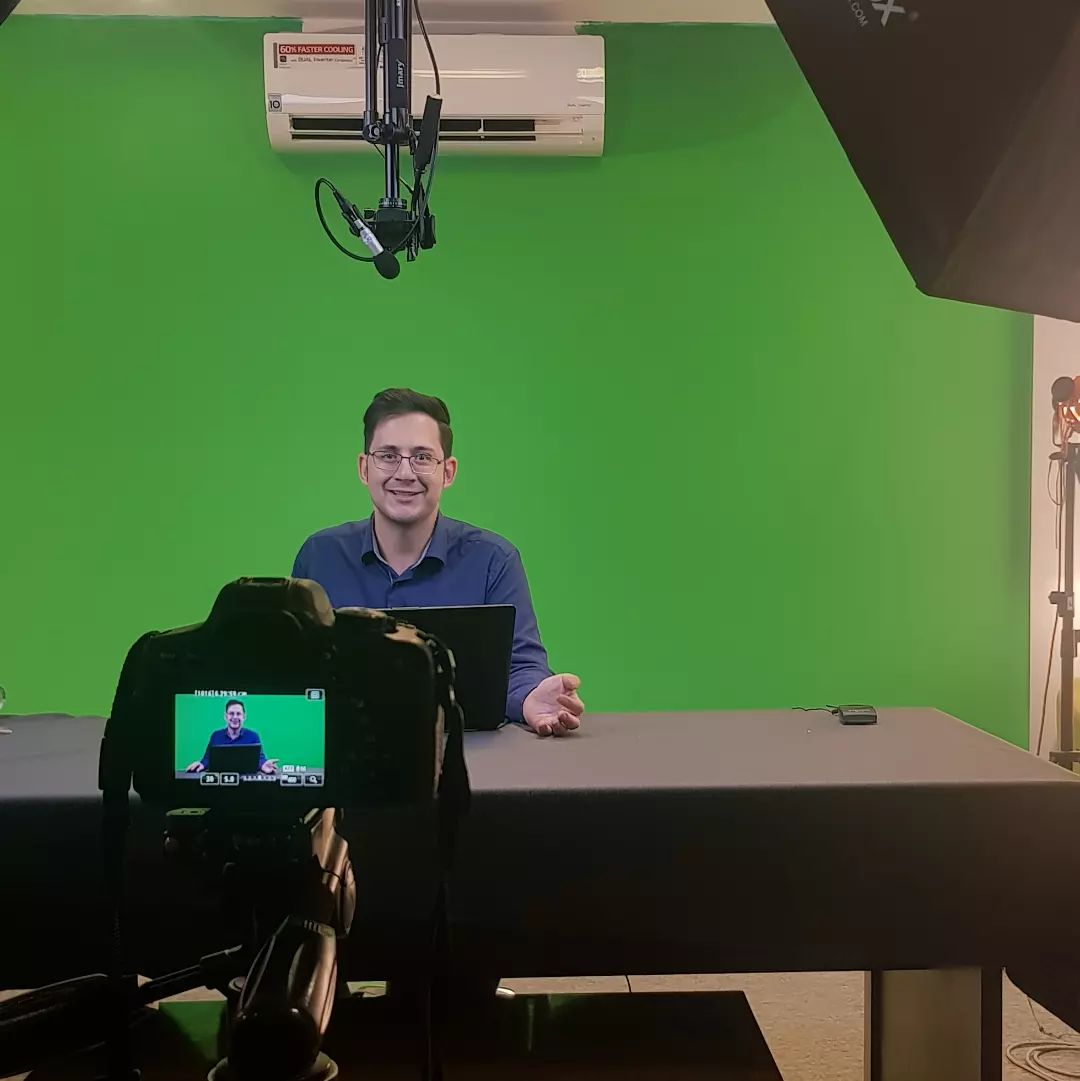

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url = "https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/akhavan_green.jpg"
response = requests.get(url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))
image


In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

instruction = "What colors are in the image?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The image features a green screen, a blue shirt, and a gray desk.</s>


In [ ]:
instruction = "How many people are in the pictures?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

There is only one person in the picture.</s>


In [ ]:
instruction = "Describe the person's face in full detail."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The person in the image is a man with short, neatly combed dark hair and glasses. He has a friendly and approachable appearance, with a slight smile on his face. His expression suggests that he is engaged and enthusiastic about the activity he is participating in, likely related to the content he is creating or presenting.


In [ ]:
instruction = "Describe the person's face in full detail in JSON format, including features such as hair, eyes, eyebrows, nose, lips, ears, glasses, facial hair, expression, and any distinctive marks."
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

```json
{
  "person": {
    "hair": {
      "color": "dark",
      "style": "short"
    },
    "eyes": {
      "color": "brown",
      "shape": "round"
    },
    "eyebrows": {
      "color": "brown",
      "shape": "straight"
    },
    "nose": {
      "shape": "straight",
      "size": "medium"
    },
    "lips": {
      "color": "pink",
      "shape": "full"
    },
    "ears": {
      "shape": "medium",
      "position": "forward"
    },
    "glasses": {
      "color": "black",
      "shape": "rectangular"
    },
    "facial_hair": {
      "type": "mustache",
      "color": "brown"
    },
    "expression": {
      "type": "smile",
      "intensity": "moderate"
    },
    "distinctive_marks": {
      "type": "none",
      "location": "none"
    }
  }
}
```</s>
